In [ ]:
import hashlib
import time
import random
import numpy as np
import os
from PIL import Image
import io


def create_mixed_content_file(size, filename):
    """Create a file with mixed content of the specified size"""
    with open(filename, 'wb') as f:
        # Text part
        text_part_size = size // 3
        text = ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789', k=text_part_size)).encode()
        f.write(text)

        # Binary part
        binary_part_size = size // 3
        binary_bytes_written = 0
        while binary_bytes_written < binary_part_size:
            chunk_size = min(binary_part_size - binary_bytes_written, 64)
            f.write(random.getrandbits(chunk_size * 8).to_bytes(chunk_size, 'big'))
            binary_bytes_written += chunk_size

        # Image part
        image_part_size = size - text_part_size - binary_part_size
        image = Image.new('RGB', (100, 100), color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
        imgByteArr = io.BytesIO()
        image.save(imgByteArr, format='PNG')
        imgByteArr = imgByteArr.getvalue()[:image_part_size]
        f.write(imgByteArr)

def hash_time(hash_function_name, filename):
    """Measure the time taken to hash data in a file with the specified hash function"""
    hash_function = hashlib.new(hash_function_name)
    start_time = time.time()
    with open(filename, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            hash_function.update(chunk)
    end_time = time.time()
    return end_time - start_time

def test_hash_function_performance(hash_function_name, data_sizes, iterations=50):
    """Test the performance of a hash function for different data sizes and types"""
    times = []

    for size in data_sizes:
        filename = f'temp_{size}.bin'
        create_mixed_content_file(size, filename)
        avg_time = np.mean([hash_time(hash_function_name, filename) for _ in range(iterations)])
        times.append(avg_time)
        os.remove(filename)
    return times


# Data sizes ranging from very small to extremely large
data_sizes = [
    10, 100, 500,                      # Very small files (10 bytes to 500 bytes)
    1024, 5*1024, 10*1024,             # Small files (1 KB to 10 KB)
    50*1024, 100*1024, 500*1024,       # Medium files (50 KB to 500 KB)
    1024*1024, 5*1024*1024, 10*1024*1024,  # Larger files (1 MB to 10 MB)
    100*1024*1024, 500*1024*1024,      # Very large files (100 MB to 500 MB)
    1024*1024*1024                     # Extremely large file (1 GB)
]


# Test SHA-1 and SHA-256 performance
sha1_times = test_hash_function_performance('sha1', data_sizes)
sha256_times = test_hash_function_performance('sha256', data_sizes)

# Print results (or plot them as needed)
print("SHA-1 Times:", sha1_times)
print("SHA-256 Times:", sha256_times)


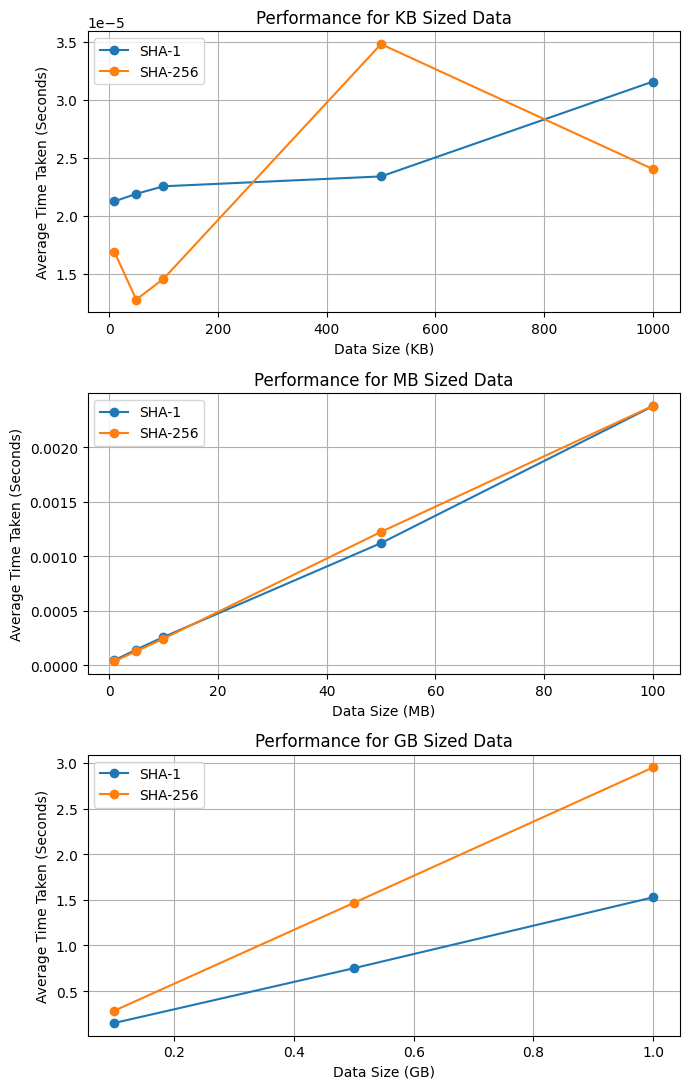

In [ ]:
import matplotlib.pyplot as plt

# Data sizes in KB, MB, and GB for demonstration purposes
data_sizes_kb = [10, 50, 100, 500, 1000]  # KB
data_sizes_mb = [1, 5, 10, 50, 100]       # MB
data_sizes_gb = [0.1, 0.5, 1]             # GB

# Convert MB and GB to KB for uniformity
data_sizes_mb_kb = [x * 1024 for x in data_sizes_mb]  # Convert MB to KB
data_sizes_gb_kb = [x * 1024 * 1024 for x in data_sizes_gb]  # Convert GB to KB

# Combine all sizes
all_sizes_kb = data_sizes_kb + data_sizes_mb_kb + data_sizes_gb_kb

# Creating subplots for different size ranges
fig, axs = plt.subplots(3, 1, figsize=(7, 11))

# Plot for KB sizes
axs[0].plot(data_sizes_kb, sha1_times[:len(data_sizes_kb)], label='SHA-1', marker='o')
axs[0].plot(data_sizes_kb, sha256_times[:len(data_sizes_kb)], label='SHA-256', marker='o')
axs[0].set_title('Performance for KB Sized Data')
axs[0].set_xlabel('Data Size (KB)')
axs[0].set_ylabel('Average Time Taken (Seconds)')
axs[0].legend()
axs[0].grid(True)

# Plot for MB sizes
axs[1].plot(data_sizes_mb, sha1_times[len(data_sizes_kb):len(data_sizes_kb) + len(data_sizes_mb)], label='SHA-1', marker='o')
axs[1].plot(data_sizes_mb, sha256_times[len(data_sizes_kb):len(data_sizes_kb) + len(data_sizes_mb)], label='SHA-256', marker='o')
axs[1].set_title('Performance for MB Sized Data')
axs[1].set_xlabel('Data Size (MB)')
axs[1].set_ylabel('Average Time Taken (Seconds)')
axs[1].legend()
axs[1].grid(True)

# Plot for GB sizes
axs[2].plot(data_sizes_gb, sha1_times[-len(data_sizes_gb):], label='SHA-1', marker='o')
axs[2].plot(data_sizes_gb, sha256_times[-len(data_sizes_gb):], label='SHA-256', marker='o')
axs[2].set_title('Performance for GB Sized Data')
axs[2].set_xlabel('Data Size (GB)')
axs[2].set_ylabel('Average Time Taken (Seconds)')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
from scipy import stats
from tabulate import tabulate

# Sample data for two conditions across different file sizes (KB, MB, GB)
data_kb_condition1 = np.array(sha1_times[:len(data_sizes_kb)])  # KB data for condition 1
data_kb_condition2 = np.array(sha256_times[:len(data_sizes_kb)])  # KB data for condition 2

data_mb_condition1 = np.array(sha1_times[len(data_sizes_kb):len(data_sizes_kb) + len(data_sizes_mb)])  # MB data for condition 1
data_mb_condition2 = np.array(sha256_times[len(data_sizes_kb):len(data_sizes_kb) + len(data_sizes_mb)])  # MB data for condition 2

data_gb_condition1 = np.array(sha1_times[-len(data_sizes_gb):])  # GB data for condition 1
data_gb_condition2 = np.array(sha256_times[-len(data_sizes_gb):])  # GB data for condition 2

# Function to perform t-test and return results
def perform_ttest(data1, data2):
    t_stat, p_value = stats.ttest_ind(data1, data2)
    return t_stat, p_value

# Performing t-tests
t_stat_kb, p_value_kb = perform_ttest(data_kb_condition1, data_kb_condition2)
t_stat_mb, p_value_mb = perform_ttest(data_mb_condition1, data_mb_condition2)
t_stat_gb, p_value_gb = perform_ttest(data_gb_condition1, data_gb_condition2)


results_table = [
    ["KB", t_stat_kb, p_value_kb],
    ["MB", t_stat_mb, p_value_mb],
    ["GB", t_stat_gb, p_value_gb]
]

print(tabulate(results_table, headers=["File Size", "T-statistic", "P-value"]))


File Size      T-statistic    P-value
-----------  -------------  ---------
KB                1.45089    0.184864
MB               -0.600569   0.564749
GB               -0.798864   0.469115


In [ ]:
import string
import random
import hashlib

def generate_random_input(length):
    """Generate a random string of specified length."""
    characters = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choice(characters) for i in range(length))

def hash_input(hash_function_name, input_data):
    """Hash the input data using the specified hash function."""
    hash_function = hashlib.new(hash_function_name)
    hash_function.update(input_data.encode())
    return hash_function.hexdigest()

def check_for_collisions(hash_function_name, inputs):
    """Check for collisions in hashed outputs."""
    hashed_outputs = set()
    for input_data in inputs:
        hash_output = hash_input(hash_function_name, input_data)
        if hash_output in hashed_outputs:
            return True, input_data  # Collision found
        hashed_outputs.add(hash_output)
    return False, None  # No collision found

num_inputs = 10000000  # Number of unique inputs to generate
input_length = 20  # Length of each input string

# Generate unique inputs
unique_inputs = [generate_random_input(input_length) for _ in range(num_inputs)]

# Check for collisions in SHA-1
collision_found_sha1, colliding_input_sha1 = check_for_collisions('sha1', unique_inputs)
print("Collision in SHA-1:", collision_found_sha1)

# Check for collisions in SHA-256
collision_found_sha256, colliding_input_sha256 = check_for_collisions('sha256', unique_inputs)
print("Collision in SHA-256:", collision_found_sha256)


Collision in SHA-1: False
Collision in SHA-256: False


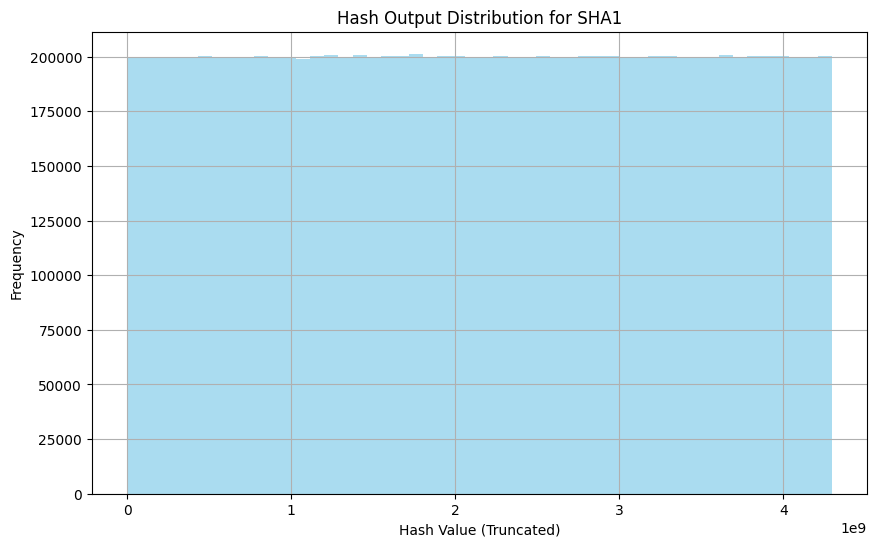

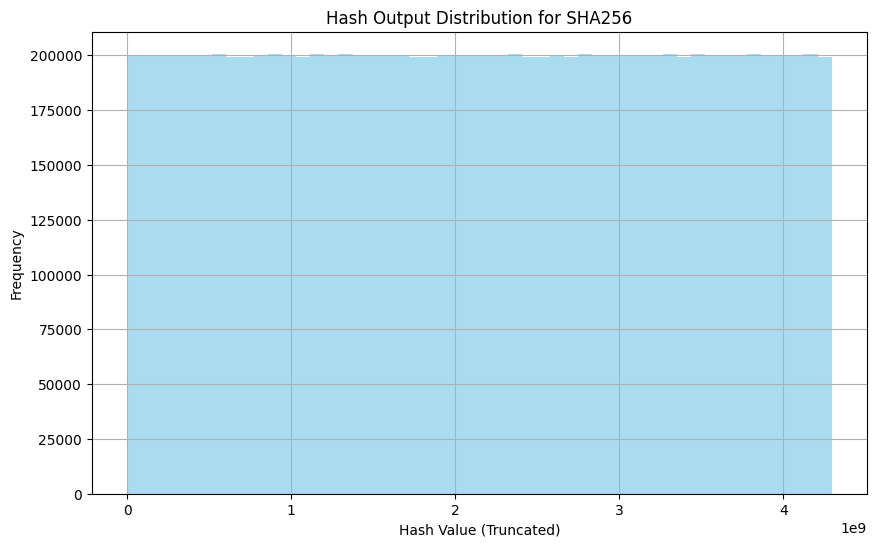

In [ ]:
import matplotlib.pyplot as plt

def plot_hash_distribution(hash_function_name, inputs, sample_size=num_inputs):
    """Plot the distribution of hash outputs for a sample of the inputs."""
    sample_hashes = [hash_input(hash_function_name, input_data)[:8] for input_data in random.sample(inputs, sample_size)]

    # Convert hash outputs to integers for plotting
    hash_values = [int(hash_output, 16) for hash_output in sample_hashes]

    plt.figure(figsize=(10, 6))
    plt.hist(hash_values, bins=50, color='skyblue', alpha=0.7)
    plt.title(f'Hash Output Distribution for {hash_function_name.upper()}')
    plt.xlabel('Hash Value (Truncated)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
plot_hash_distribution('sha1', unique_inputs)
plot_hash_distribution('sha256', unique_inputs)


# **Collision Experiment**

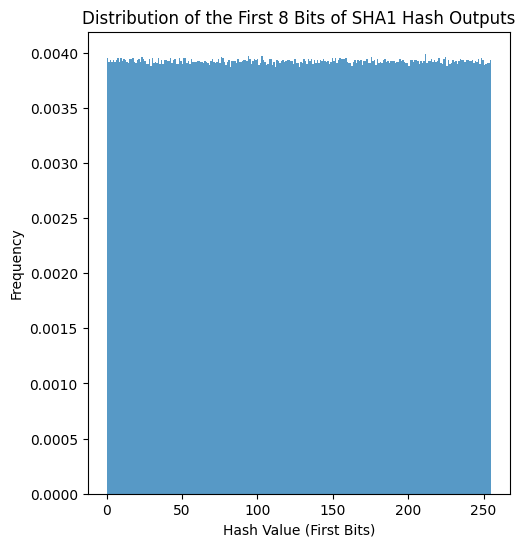

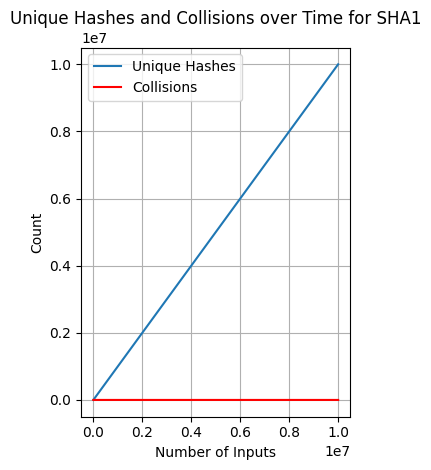

No collisions found in SHA1.


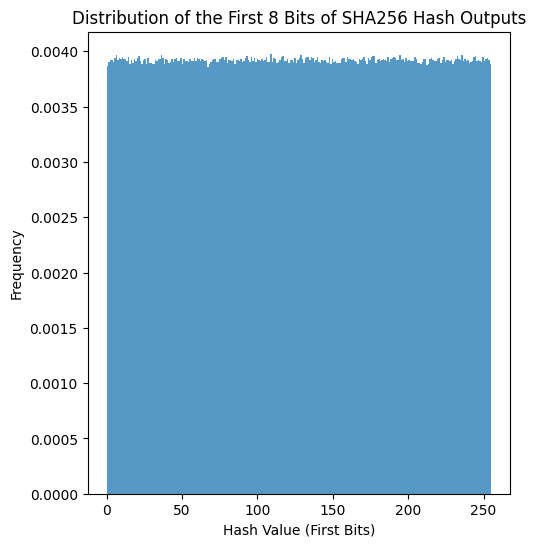

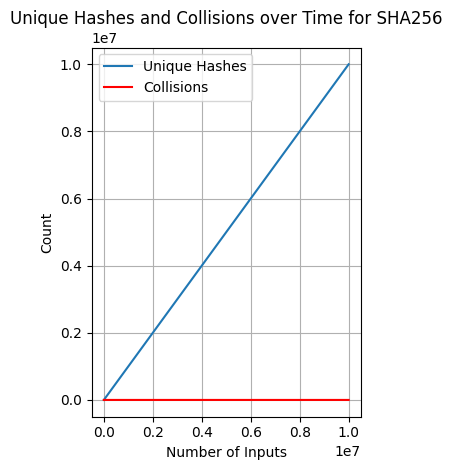

No collisions found in SHA256.


In [ ]:
import hashlib
import random
import string
import matplotlib.pyplot as plt
import numpy as np

def generate_input(length):
    """Generate a random string of specified length."""
    characters = string.ascii_letters + string.digits + string.punctuation
    return ''.join(random.choices(characters, k=length))

def hash_input(input_string, algorithm):
    """Return the hash of the given input using the specified algorithm."""
    hash_function = hashlib.new(algorithm)
    hash_function.update(input_string.encode())
    return hash_function.hexdigest()

def plot_hash_distribution(hashes, num_bits, algorithm):
    """Plot the distribution of the specified number of bits of each hash."""
    extracted_bits = [int(hash[:num_bits // 4], 16) for hash in hashes]  # Convert hex to int

    plt.hist(extracted_bits, bins=2**num_bits, density=True, alpha=0.75)
    plt.title(f'Distribution of the First {num_bits} Bits of {algorithm.upper()} Hash Outputs')
    plt.xlabel('Hash Value (First Bits)')
    plt.ylabel('Frequency')
    plt.show()

def collision_test_with_visualization(iterations, input_length, num_bits, algorithms):
    """Test for collisions in hash functions and visualize the results."""
    for algorithm in algorithms:
        hashes = {}
        hash_outputs = []
        unique_hashes = []
        collision_counts = []

        for i in range(1, iterations + 1):
            input_str = generate_input(input_length)
            hash_output = hash_input(input_str, algorithm)
            hash_outputs.append(hash_output)

            if hash_output in hashes:
                collision_counts.append(collision_counts[-1] + 1 if collision_counts else 1)
                print(f"Collision found in {algorithm.upper()}: '{input_str}' and '{hashes[hash_output]}' produce the same hash.")
            else:
                hashes[hash_output] = input_str
                collision_counts.append(collision_counts[-1] if collision_counts else 0)

            unique_hashes.append(len(hashes))

        # Plotting the distribution of hash outputs
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plot_hash_distribution(hash_outputs, num_bits, algorithm)

        # Plotting the collisions over number of inputs
        plt.subplot(1, 2, 2)
        plt.plot(range(1, iterations + 1), unique_hashes, label='Unique Hashes')
        plt.plot(range(1, iterations + 1), collision_counts, label='Collisions', color='red')
        plt.xlabel('Number of Inputs')
        plt.ylabel('Count')
        plt.title(f'Unique Hashes and Collisions over Time for {algorithm.upper()}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        if any(collision_counts):
            print(f"{collision_counts[-1]} collisions found in {algorithm.upper()}.")
        else:
            print(f"No collisions found in {algorithm.upper()}.")

# Example usage
collision_test_with_visualization(10000000, 10, 8, ["sha1", "sha256"])  # Test both SHA-1 and SHA-256

